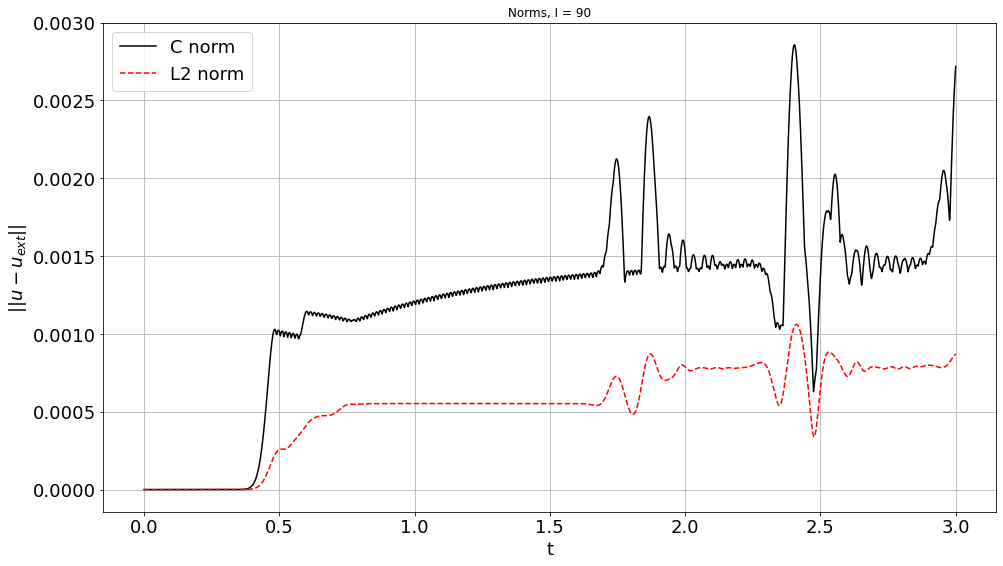

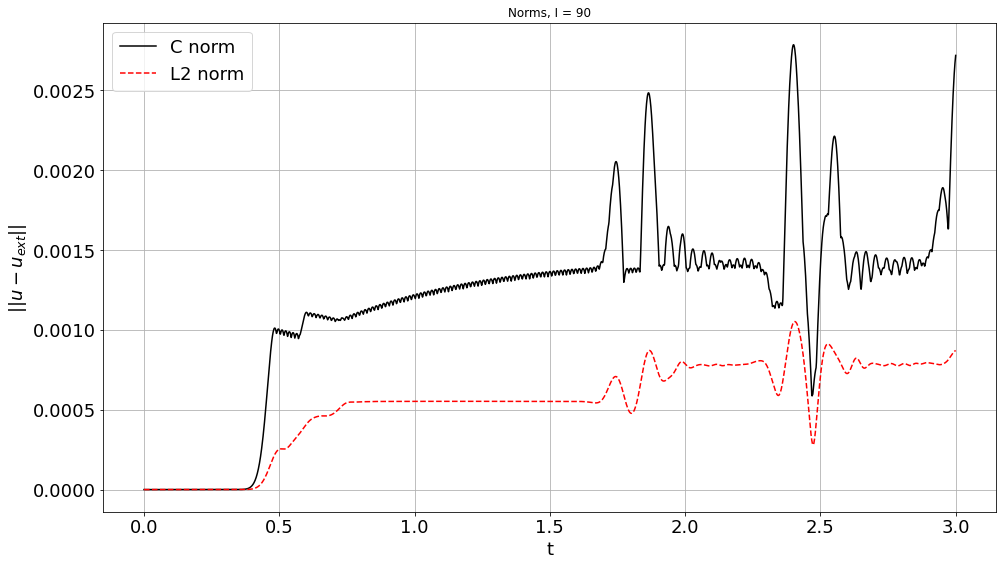

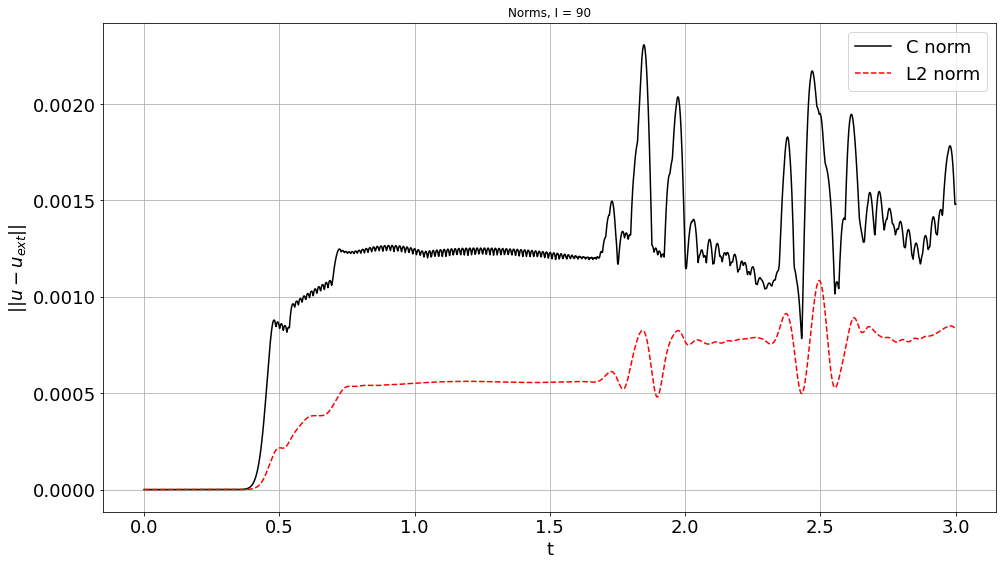

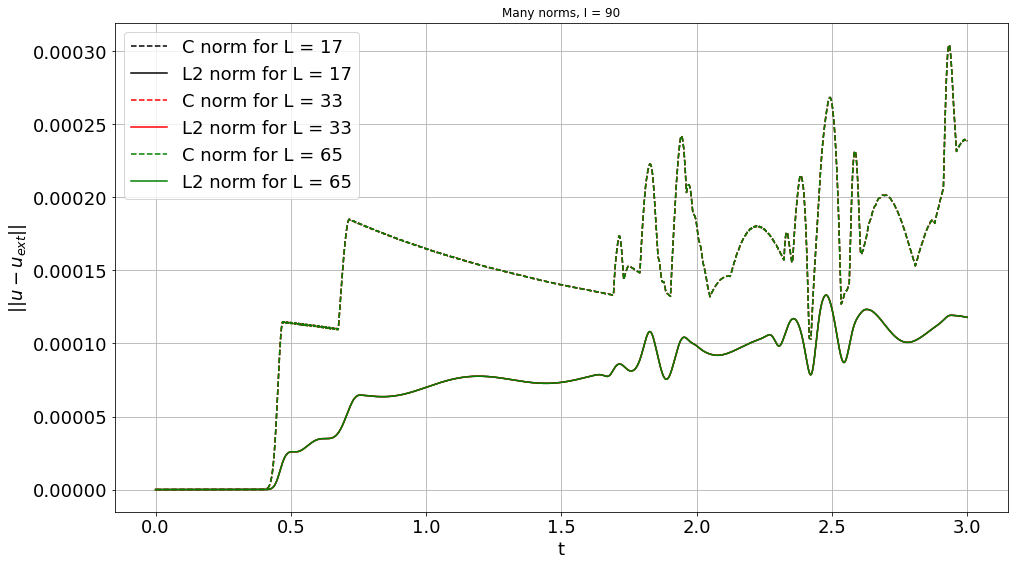

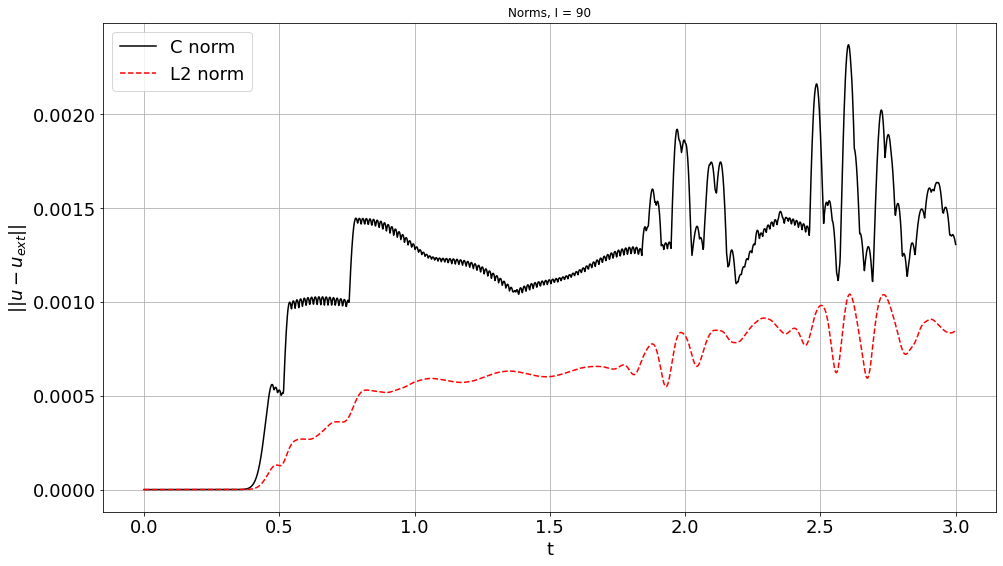

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera
import os
from numba import njit

def v0(r, a, b) : 
    if (r > a) and (r < b) : 
        return np.exp((-4*(2*r-(a+b))**2) / ((b-a)**2 - (2*r - (a+b))**2))
    else : 
        return 0
    
    
def get_coeffs(filename) :
    f = open(os.getcwd() + "\kern\\" + filename, "r")
    al = np.array([])
    bl = np.array([])
    
    for line in f:
        al = np.append(al, float(line.split()[0]) + 1j*float(line.split()[1]))
        bl = np.append(bl, float(line.split()[2]) + 1j*float(line.split()[3]))
    
    return al, bl
    

def solver(r_min, r_max, T, I, c, a, b, C, filename, lmbda) :
    d = 1
    h = (r_max - r_min) / I
    r = np.zeros(I+2)
    for i in range(len(r)) :
        r[i] = r_min + (i - 0.5) * h
    rr = lambda i: r_min + (i - 0.5)*h    
    tau = C*h/c
    N = int(T/tau) + 1
    t = np.linspace(0, T, N)
    al, bl = get_coeffs(filename)
    al = c*lmbda**2*al
    bl = c*lmbda*bl
    
    u = np.zeros((len(t), len(r)))
    A = np.zeros((len(t), len(al)), dtype = complex)
    
    for i in range(len(r)) : 
        u[0, i] = v0(r[i], a, b)
    
    for i in range(1, len(r) - 1) : 
        u[1, i] = u[0, i] + 1/2 * tau**2*c**2/(r[i]**(d-1) * h)*(rr(i+0.5)**(d-1)* \
                (u[0, i+1] - u[0, i])/h - rr(i-0.5)**(d-1) * (u[0, i] - u[0, i-1])/h) - \
                1/2*tau**2*c**2*lmbda**2*u[0, i]
    u[1, 0] = -u[1, 1]
    conv = 0 # A[1, k] = A[0, k] = 0
    #for k in range(len(al)) :
        #conv += al[k]*np.exp(bl[k]*t[1])
    u[1, -1] = u[0, -2] + (1-c*tau/h) / (1+c*tau/h) * (u[0, -1] - u[1, -2]) - \
    2*c*tau/(c*tau/h+1) * conv.real
    for n in range(1, len(t) - 1) : 
        for i in range(1, len(r) - 1) :
            u[n + 1,i] = 2 * u[n, i] - u[n-1, i] + tau**2*c**2/(r[i]**(d-1) * h)* \
            (rr(i+0.5)**(d-1)* (u[n, i+1] - u[n, i])/h - rr(i-0.5)**(d-1) * \
            (u[n, i] - u[n, i-1])/h) - tau**2*c**2*lmbda**2*u[n, i]
            
        u[n + 1, 0] = -u[n + 1, 1]
        conv = 0 #от слова convolution
        for k in range(len(al)) :
            A[n+1, k] = np.exp(bl[k] * tau) * A[n, k] + tau/6 * \
                (np.exp(bl[k] * tau) * (u[n-1, -1] + u[n, -2])/2 + \
                4 * np.exp(bl[k] * tau/2) * (u[n, -1] + u[n, -2])/2 + \
                (u[n, -1] + u[n+1, -3])/2)
            conv += al[k]*A[n+1, k]
        u[n + 1, -1] = u[n, -2] + (1-c*tau/h) / (1+c*tau/h) * (u[n, -1] - u[n + 1, -2]) - \
        2*c*tau/(c*tau/h+1) * conv.real
    
    return u, r, t, h

def draw_initial_extended(u, r, t, u1, r1, t1) : 
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    
    camera = Camera(fig)
    for i in range(len(t)) : 
        ax.plot(r, u[i, :], linestyle = 'None', marker = 'o', color = 'black', markersize = 8)
        ax.plot(r1, u1[i, :], linestyle = 'None', marker = 'o', color = 'red', markersize = 5)
        camera.snap()
        plt.legend(['initial interval', 'extended interval'], loc = 'best', fontsize = 18)
        plt.xlabel('r', fontsize = 18)
        plt.ylabel('u', fontsize = 18)
        
    xax = ax.xaxis
    xlocs = xax.get_ticklocs()
    xlabels = xax.get_ticklabels()
    xlines = xax.get_ticklines()

    xax.grid(True)

    for label in xlabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
    
    yax = ax.yaxis
    ylocs = yax.get_ticklocs()
    ylabels = yax.get_ticklabels()
    ylines = yax.get_ticklines()
    yax.grid(True)

    for label in ylabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
        
    plt.title("Initial_and_extended, I = 90")
        
    animation = camera.animate()
    animation.save('Initial_and_extended.gif', writer='PillowWriter', fps = 30)
    
    
def draw_difference(u, r, t, u1, r1, t1) : 
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    
    camera = Camera(fig)
    for i in range(len(t)) : 
        ax.plot(r, u[i, :] - u1[i, :len(r)], linestyle = 'None', marker = 'o', color = 'black', markersize = 5)
        camera.snap()
        plt.legend([r'$u - u_{ext}$'], loc = 'best', fontsize = 18)
        plt.xlabel('r', fontsize = 18)
        plt.ylabel(r'$u - u_{ext}$', fontsize = 18)
        
    xax = ax.xaxis
    xlocs = xax.get_ticklocs()
    xlabels = xax.get_ticklabels()
    xlines = xax.get_ticklines()

    xax.grid(True)

    for label in xlabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
    
    yax = ax.yaxis
    ylocs = yax.get_ticklocs()
    ylabels = yax.get_ticklabels()
    ylines = yax.get_ticklines()
    yax.grid(True)

    for label in ylabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
          
    plt.title("Difference, I = 90")
        
    animation = camera.animate()
    animation.save('Difference.gif', writer='PillowWriter', fps = 30)
    
def C_norm(u) :
    return np.max(np.abs(u))

def L2_norm(u, h) : 
    return np.sqrt(np.sum(h * np.abs(u)**2))

def draw_norm(u, u1, t, r, h) :
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    
    C = np.zeros(len(t))
    L = np.zeros(len(t))
    for n in range(len(t)) :
        C[n] = C_norm(u[n, :] - u1[n, :len(r)])
        L[n] = L2_norm(u[n, :] - u1[n, :len(r)], h)
        
    ax.plot(t, C, linestyle = '-', color = 'black', markersize = 5, label = 'C norm')
    ax.plot(t, L, linestyle = '--', color = 'red', markersize = 5, label = 'L2 norm')    
        
    xax = ax.xaxis
    xlocs = xax.get_ticklocs()
    xlabels = xax.get_ticklabels()
    xlines = xax.get_ticklines()

    xax.grid(True)

    for label in xlabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
    
    yax = ax.yaxis
    ylocs = yax.get_ticklocs()
    ylabels = yax.get_ticklabels()
    ylines = yax.get_ticklines()
    yax.grid(True)

    for label in ylabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
        
    plt.xlabel('t', fontsize = 18)
    plt.ylabel(r'||$u - u_{ext}$||', fontsize = 18) 
    plt.legend(loc = 'best', fontsize = 18)
    name = "norms.jpg"
    plt.title("Norms, I = 90")
    plt.savefig(fname = name)

def getNewU(u,tIndex,rIndex):
    newU = np.zeros((len(tIndex), len(rIndex)))
    for n in range(len(tIndex)):
        for i in range(len(rIndex)):
            newU[n,i] = u[tIndex[n], rIndex[i]]
    return newU

def getNewUU(u, tIndex) : 
    newU = np.zeros(len(tIndex))
    for n in range(len(tIndex)) :
        newU[n] = u[tIndex[n]]
    return newU

def check_convergence_ext(u, u_ext, u1, u1_ext, u2, u2_ext, t, t1, t2, r, r1, r2, h, h1, h2) :
    C = np.zeros(len(t))
    L = np.zeros(len(t))
    for n in range(len(t)) :
        C[n] = C_norm(u[n, :] - u_ext[n, :len(r)])
        L[n] = L2_norm(u[n, :] - u_ext[n, :len(r)], h)
        
    C1 = np.zeros(len(t1))
    L1 = np.zeros(len(t1))
    for n in range(len(t1)) :
        C1[n] = C_norm(u1[n, :] - u1_ext[n, :len(r1)])
        L1[n] = L2_norm(u1[n, :] - u1_ext[n, :len(r1)], h1)
        
    C2 = np.zeros(len(t2))
    L2 = np.zeros(len(t2))
    for n in range(len(t2)) :
        C2[n] = C_norm(u2[n, :] - u2_ext[n, :len(r2)])
        L2[n] = L2_norm(u2[n, :] - u2_ext[n, :len(r2)], h2)
        
    tIndex1 = [i for i in range(0,len(t1),3)]
    tIndex2 = [i for i in range(0,len(t2),9)]
    newL1 = getNewUU(L1, tIndex1)
    newC1 = getNewUU(C1, tIndex1)
    newL2 = getNewUU(L2, tIndex2)
    newC2 = getNewUU(C2, tIndex2)
    
        
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
        
    y_C = np.zeros(len(t))
    yy_C = np.zeros(len(t))
    y_L = np.zeros(len(t))
    yy_L = np.zeros(len(t))
    #for n in range(len(t)) :
        #if (np.isclose(C[n], 0, atol = 1e-04)) or (np.isclose(C1[3*n], 0, atol = 1e-04)) :
        #    y_C[n] = 9
        #else:
        #    y_C[n] = C[n] / C1[3*n]
            
        #if (np.isclose(C1[3*n], 0, atol = 1e-04)) or (np.isclose(C2[9*n], 0, atol = 1e-04)) :
        #    yy_C[n] = 9
        #else:
        #    yy_C[n] = C1[3*n] / C2[9*n]
            
        #if (np.isclose(L[n], 0, atol = 1e-04)) or (np.isclose(L1[3*n], 0, atol = 1e-04)) :
        #    y_L[n] = 9
        #else:
        #    y_L[n] = L[n] / L1[3*n]
            
        #if (np.isclose(L1[3*n], 0, atol = 1e-04)) or (np.isclose(L2[9*n], 0, atol = 1e-04)) :
        #    yy_L[n] = 9
        #else:
        #    yy_L[n] = L1[3*n] / L2[9*n]
    
    
    for n in range(len(t)) :
        y_C[n] = C[n] / newC1[n]
        yy_C[n] = newC1[n] / newC2[n]
        y_L[n] = L[n] / newL1[n]
        yy_L[n] = newL1[n] / newL2[n]
        if y_C[n] > 100 : 
            y_C[n] = 9
        if yy_C[n] > 100 : 
            yy_C[n] = 9
        if y_L[n] > 100 :
            y_L[n] = 9
        if yy_L[n] > 100 :
            yy_L[n] = 9
        
    a9 = np.linspace(0, t[-1], len(t) - 1)
    a9.fill(9)
    ax.plot(t[1:], y_C[1:], linestyle = "--", color = 'black', label = "C norm for N-1 = 30, 90")
    ax.plot(t[1:], yy_C[1:], linestyle = "--", color = 'red', label = "C norm for N-1 = 90, 270")
    ax.plot(t[1:], y_L[1:], linestyle = "-", color = 'black', label = "L2 norm for N-1 = 30, 90")
    ax.plot(t[1:], yy_L[1:], linestyle = "-", color = 'red', label = "L2 norm for N-1 = 90, 270")
    ax.plot(t[1:], a9, linestyle = '-', color = 'grey', linewidth = 5, label = 'reference')
    
    xax = ax.xaxis
    xlocs = xax.get_ticklocs()
    xlabels = xax.get_ticklabels()
    xlines = xax.get_ticklines()

    xax.grid(True)

    for label in xlabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
    
    yax = ax.yaxis
    ylocs = yax.get_ticklocs()
    ylabels = yax.get_ticklabels()
    ylines = yax.get_ticklines()
    yax.grid(True)

    for label in ylabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
        
    plt.xlabel('t', fontsize = 18)
    plt.ylabel(r'||$u - u_{ext}$|| / ||$u_1 - u_{1ext}$||', fontsize = 18) 
    plt.legend(loc = 'best', fontsize = 18)
    name = "convergence_ext.jpg"
    plt.title("Convergence_ext")
    plt.savefig(fname = name)
    
def check_convergence_like_analytical(u, u_ext, u1, u1_ext, u2, u2_ext, t, t1, t2, r, r1, r2, h, h1, h2) :
    tIndex1 = [i for i in range(0,len(t1),3)]
    tIndex2 = [i for i in range(0,len(t2),9)]
    rIndex1 = [i for i in range(2,len(r1),3)]
    rIndex2 = [i for i in range(5,len(r2),9)]    
    newu = u[:, 1:-1]
    newu1 = getNewU(u1, tIndex1, rIndex1)
    newu2 = getNewU(u2, tIndex2, rIndex2)
    newu_ext = u_ext[:, 1:len(r)]
    temp1_ext = u1_ext[:, :len(r1)]
    temp2_ext = u2_ext[:, :len(r2)]
    newu1_ext = getNewU(temp1_ext, tIndex1, rIndex1)
    newu2_ext = getNewU(temp2_ext, tIndex2, rIndex2)
    print(np.shape(newu), np.shape(newu1), np.shape(newu2), np.shape(newu_ext),
          np.shape(newu1_ext), np.shape(newu2_ext))
    
    C = np.zeros(len(t)-1)
    L = np.zeros(len(t)-1)
    for n in range(len(t)-1) :
        if np.isclose(C_norm(newu1[n] - newu1_ext[n]), 0, atol = 1e-4) : 
            C[n] = 9
        else :
            C[n] = C_norm(newu[n] - newu1_ext[n]) / C_norm(newu1[n] - newu1_ext[n])
            
        if np.isclose(L2_norm(newu1[n] - newu1_ext[n], h), 0, atol = 1e-4) :   
            L[n] = 9
        else :
            L[n] = L2_norm(newu[n] - newu1_ext[n], h) / L2_norm(newu1[n] - newu1_ext[n], h)
            
    C1 = np.zeros(len(t)-1)
    L1 = np.zeros(len(t)-1)
    for n in range(len(t)-1) :
        if np.isclose(C_norm(newu2[n] - newu2_ext[n]), 0, atol = 1e-4) :
            C1[n] = 9
        else : 
            C1[n] = C_norm(newu1[n] - newu2_ext[n]) / C_norm(newu2[n] - newu2_ext[n])
            
        if np.isclose(L2_norm(newu2[n] - newu2_ext[n], h), 0, atol = 1e-4) :
            L1[n] = 9
        else :
            L1[n] = L2_norm(newu1[n] - newu2_ext[n], h) / L2_norm(newu2[n] - newu2_ext[n], h)
        
        
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
        
    
    a9 = np.linspace(0, t[-1], len(t) - 1)
    a9.fill(9)
    ax.plot(t[1:], C, linestyle = "--", color = 'black', label = "C norm for N-1 = 30, 90")
    ax.plot(t[1:], C1, linestyle = "--", color = 'red', label = "C norm for N-1 = 90, 270")
    ax.plot(t[1:], L, linestyle = "-", color = 'black', label = "L2 norm for N-1 = 30, 90")
    ax.plot(t[1:], L1, linestyle = "-", color = 'red', label = "L2 norm for N-1 = 90, 270")
    ax.plot(t[1:], a9, linestyle = '-', color = 'grey', linewidth = 5, label = 'reference')
    
    xax = ax.xaxis
    xlocs = xax.get_ticklocs()
    xlabels = xax.get_ticklabels()
    xlines = xax.get_ticklines()

    xax.grid(True)

    for label in xlabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
    
    yax = ax.yaxis
    ylocs = yax.get_ticklocs()
    ylabels = yax.get_ticklabels()
    ylines = yax.get_ticklines()
    yax.grid(True)

    for label in ylabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
        
    plt.xlabel('t', fontsize = 18)
    plt.ylabel(r'||$u - u_{1ext}$|| / ||$u_1 - u_{1ext}$||', fontsize = 18) 
    plt.legend(loc = 'best', fontsize = 18)
    name = "convergence_like_analytical.jpg"
    plt.title("Convergence analytical")
    plt.savefig(fname = name)
    
def check_convergence (u, u1, u2, t, t1, t2, r, r1, r2, h, h1, h2) :
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
                   
    tIndex1 = [i for i in range(0,len(t1),3)]
    tIndex2 = [i for i in range(0,len(t2),9)]
    rIndex1 = [i for i in range(2,len(r1),3)]
    rIndex2 = [i for i in range(5,len(r2),9)]    
    newu = u[:, 1:-1]
    newu1 = getNewU(u1, tIndex1, rIndex1)
    newu2 = getNewU(u2, tIndex2, rIndex2)
    
    
    Cnorm = np.zeros(len(t)-1)
    Lnorm = np.zeros(len(t)-1)
    for n in range(len(Cnorm)) :
        Cnorm[n] = C_norm(newu[n] - newu1[n]) / C_norm(newu1[n] - newu2[n])
        Lnorm[n] = L2_norm(newu[n] - newu1[n], h) / L2_norm(newu1[n] - newu2[n], h)
    a9 = np.linspace(0, t[-1], len(t) - 1)
    a9.fill(9)
        
    ax.plot(t[1:], Cnorm, linestyle = '--', color = 'black', label = 'C norm')
    ax.plot(t[1:], Lnorm, linestyle = '--', color = 'red', label = 'L2 norm')
    ax.plot(t[1:], a9, linestyle = '-', color = 'grey', label = 'reference')
                   
    xax = ax.xaxis
    xlocs = xax.get_ticklocs()
    xlabels = xax.get_ticklabels()
    xlines = xax.get_ticklines()

    xax.grid(True)

    for label in xlabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
    
    yax = ax.yaxis
    ylocs = yax.get_ticklocs()
    ylabels = yax.get_ticklabels()
    ylines = yax.get_ticklines()
    yax.grid(True)

    for label in ylabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
        
    plt.xlabel('t', fontsize = 18)
    plt.ylabel(r'||$u - u_1$|| / ||$u_1 - u_2$||', fontsize = 18) 
    plt.legend(loc = 'best', fontsize = 18)
    name = "convergence.jpg"
    plt.title("Convergence")
    plt.savefig(fname = name)
    
def draw_many_norms(u, u_ext, u1, u1_ext, u2, u2_ext, t, r, h) :
    fig = plt.figure(figsize = (16, 9))
    ax = fig.add_subplot(111)
    
    C = np.zeros(len(t))
    L = np.zeros(len(t))
    for n in range(len(t)) :
        C[n] = C_norm(u[n, :] - u_ext[n, :len(r)])
        L[n] = L2_norm(u[n, :] - u_ext[n, :len(r)], h)
        
    C1 = np.zeros(len(t))
    L1 = np.zeros(len(t))
    for n in range(len(t)) :
        C1[n] = C_norm(u1[n, :] - u1_ext[n, :len(r)])
        L1[n] = L2_norm(u1[n, :] - u1_ext[n, :len(r)], h)
        
    C2 = np.zeros(len(t))
    L2 = np.zeros(len(t))
    for n in range(len(t)) :
        C2[n] = C_norm(u2[n, :] - u2_ext[n, :len(r)])
        L2[n] = L2_norm(u2[n, :] - u2_ext[n, :len(r)], h)
        
    ax.plot(t, C, linestyle = '--', color = 'black', markersize = 5, label = 'C norm for L = 17')
    ax.plot(t, L, linestyle = '-', color = 'black', markersize = 5, label = 'L2 norm for L = 17') 
    ax.plot(t, C1, linestyle = '--', color = 'red', markersize = 5, label = 'C norm for L = 33')
    ax.plot(t, L1, linestyle = '-', color = 'red', markersize = 5, label = 'L2 norm for L = 33')
    ax.plot(t, C2, linestyle = '--', color = 'green', markersize = 5, label = 'C norm for L = 65')
    ax.plot(t, L2, linestyle = '-', color = 'green', markersize = 5, label = 'L2 norm for L = 65')
        
    xax = ax.xaxis
    xlocs = xax.get_ticklocs()
    xlabels = xax.get_ticklabels()
    xlines = xax.get_ticklines()

    xax.grid(True)

    for label in xlabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
    
    yax = ax.yaxis
    ylocs = yax.get_ticklocs()
    ylabels = yax.get_ticklabels()
    ylines = yax.get_ticklines()
    yax.grid(True)

    for label in ylabels :
        label.set_color('black')
        label.set_rotation(0)
        label.set_fontsize(18)
        
    plt.xlabel('t', fontsize = 18)
    plt.ylabel(r'||$u - u_{ext}$||', fontsize = 18) 
    plt.legend(loc = 'best', fontsize = 18)
    name = "many_norms.jpg"
    plt.title("Many norms, I = 90")
    plt.savefig(fname = name)

r_min = 0.
r_max = 1.8
c = 1.5
C = 0.1
a = 0.6
b = 1.2
T = 3
I = 30
filename = "coef16.dat"
r_max_ext = 2*r_max - r_min

lmbda_interval = [0, 1, 3, 6]
#lmbda_interval = [1]

for lmbda in lmbda_interval : 
    I = 90
    u, r, t, h = solver(r_min, r_max, T, I, c, a, b, C, filename, lmbda)
    u_ext, r_ext, t_ext, h_ext = solver(r_min, r_max_ext, T, 2*I, c, a, b, C, filename, lmbda)
    os.chdir(os.getcwd() + "\outData\\lambda_" + str(lmbda))
    #draw_initial_extended(u, r, t, u_ext, r_ext, t_ext)
    draw_norm(u, u_ext, t, r, h)
    #draw_difference(u, r, t, u_ext, r_ext, t_ext)
    os.chdir(os.getcwd().replace("\outData\\lambda_" + str(lmbda), "")) 
    
    I = 30
    
    u, r, t, h = solver(r_min, r_max, T, I, c, a, b, C, filename, lmbda)
    u_ext, r_ext, t_ext, h_ext = solver(r_min, r_max_ext, T, 2*I, c, a, b, C, filename, lmbda)
    
    u1, r1, t1, h1 = solver(r_min, r_max, T, 3*I, c, a, b, C, filename, lmbda)
    u1_ext, r1_ext, t1_ext, h1_ext = solver(r_min, r_max_ext, T, 2*3*I, c, a, b, C, filename, lmbda)
    
    u2, r2, t2, h2 = solver(r_min, r_max, T, 9*I, c, a, b, C, filename, lmbda)
    u2_ext, r2_ext, t2_ext, h2_ext = solver(r_min, r_max_ext, T, 2*9*I, c, a, b, C, filename, lmbda)
    
    os.chdir(os.getcwd() + "\outData\\lambda_" + str(lmbda))
    #check_convergence_like_analytical(u, u_ext, u1, u1_ext, u2, u2_ext, t, t1, t2, r, r1, r2, h, h1, h2)
    #check_convergence_ext(u, u_ext, u1, u1_ext, u2, u2_ext, t, t1, t2, r, r1, r2, h, h1, h2)
    #check_convergence (u, u1, u2, t, t1, t2, r, r1, r2, h, h1, h2)
    os.chdir(os.getcwd().replace("\outData\\lambda_" + str(lmbda), "")) 
    
    if lmbda == 3 :
        filename = "coef17.dat"
        u, r, t, h = solver(r_min, r_max, T, 9*I, c, a, b, C, filename, lmbda) 
        u_ext, r_ext, t_ext, h_ext = solver(r_min, r_max_ext, T, 18*I, c, a, b, C, filename, lmbda)
        
        filename = "coef33.dat"
        u1, r1, t1, h1 = solver(r_min, r_max, T, 9*I, c, a, b, C, filename, lmbda)
        u1_ext, r1_ext, t1_ext, h1_ext = solver(r_min, r_max_ext, T, 18*I, c, a, b, C, filename, lmbda)
        
        filename = "coef65.dat"
        u2, r2, t2, h2 = solver(r_min, r_max, T, 9*I, c, a, b, C, filename, lmbda)
        u2_ext, r2_ext, t2_ext, h2_ext = solver(r_min, r_max_ext, T, 18*I, c, a, b, C, filename, lmbda)
        
        os.chdir(os.getcwd() + "\outData\\lambda_" + str(lmbda))
        draw_many_norms(u, u_ext, u1, u1_ext, u2, u2_ext, t, r, h)
        os.chdir(os.getcwd().replace("\outData\\lambda_" + str(lmbda), "")) 
        filename = "coef16.dat"